# Pre-processing & Modeling

* __Pre-processing: read the image in DCM format and convert them to PNG format__

* __Bulid and train a Image Classification__
  - There are four classes:
  
        1. Typical Appearance: Multifocal bilateral, peripheral opacities with rounded morphology, lower lung–predominant distribution

        2. Indeterminate Appearance: Absence of typical findings AND unilateral, central or upper lung predominant distribution

        3. Atypical Appearance: Pneumothorax, pleural effusion, pulmonary edema, lobar consolidation, solitary lung nodule or mass, diffuse tiny nodules, cavity

        4. Negative for Pneumonia: No lung opacities


## 1 Installs and Imports 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -c conda-forge gdcm -y

In [2]:
!pip install tensorflow_addons

     |████████████████████████████████| 686kB 4.3MB/s 


In [60]:
import os
import math 
import pandas as pd
import numpy as np
import seaborn as sns
#import pydicom
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization,Activation
from tensorflow.keras import optimizers 
import tensorflow_addons as tfa 
from keras.callbacks import EarlyStopping
from keras import models  

## 2 Loading the Data

In [ ]:
path = '../input/covid19-detection-datawrangling-eda/data_information.csv'
data_info_df = pd.read_csv(path)
data_info_df.head()

,boxes,label,StudyInstanceUID,image_path,study_id,image_id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,num_boxes,class_name
0,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,../input/siim-covid19-detection/train/5776db0c...,5776db0cec75_study,000a312787f2_image,0,1,0,0,2,Typical Appearance
1,[],none 1 0 0 1 1,ff0879eb20ed,../input/siim-covid19-detection/train/ff0879eb...,ff0879eb20ed_study,000c3a3f293f_image,1,0,0,0,0,Negative for Pneumonia
2,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,../input/siim-covid19-detection/train/9d514ce4...,9d514ce429a7_study,0012ff7358bc_image,0,1,0,0,2,Typical Appearance
3,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,../input/siim-covid19-detection/train/28dddc85...,28dddc8559b2_study,001398f4ff4f_image,0,0,0,1,1,Atypical Appearance
4,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,../input/siim-covid19-detection/train/dfd9fdd8...,dfd9fdd85a3e_study,001bd15d1891_image,0,1,0,0,2,Typical Appearance


## 3 Pre-processing

### 3.1 Create the Functions for Reading and Rescaling the Dcm Image 

In [ ]:
def read_dcm_image(image_info):
    """
    This function is used to read the dcm image
    
    image_info: dictionary that includes the image id  
                image path
    return:
    numpy array of the image pixels in range 0-255
    """
    img = pydicom.dcmread(image_info['image_path'])
    arr = img.pixel_array
    arr = arr - np.min(arr)
    arr = arr / np.max(arr)
    arr = (arr * 255).astype(np.uint8)   
    
    return arr

### 3.2 Plot the Distribution Of the original and rescaled imamge

(array([2451.,   80.,   64.,   25.,   29.,   32.,   40.,   59.,   56.,
          47.,   40.,   61.,   39.,   84.,  119.,  167.,  245.,  443.,
         132.,   35.]),
 array([   0.  ,  204.75,  409.5 ,  614.25,  819.  , 1023.75, 1228.5 ,
        1433.25, 1638.  , 1842.75, 2047.5 , 2252.25, 2457.  , 2661.75,
        2866.5 , 3071.25, 3276.  , 3480.75, 3685.5 , 3890.25, 4095.  ]),
 <BarContainer object of 20 artists>)

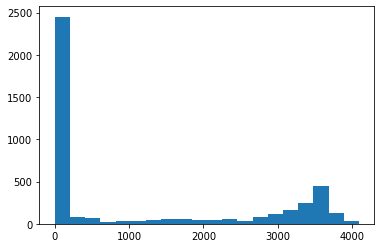

In [ ]:
# before rescale
im_origin = pydicom.dcmread(data_info_df.image_path[10]).pixel_array
plt.hist(im_origin[0], bins=20)

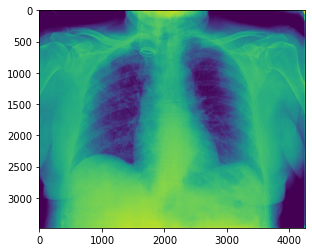

In [ ]:
# show the original image
plt.imshow(im_origin)

(array([[1176.,   65.,   36., ...,    0.,    0.,    0.],
        [1172.,   69.,   37., ...,    0.,    0.,    0.],
        [1176.,   60.,   39., ...,    0.,    0.,    0.],
        ...,
        [   5.,   30.,   74., ...,   88.,   86.,  306.],
        [   0.,    0.,    0., ...,  260.,  622., 2195.],
        [   0.,    0.,    0., ...,    9.,   39., 3432.]]),
 array([  0.  ,  12.75,  25.5 ,  38.25,  51.  ,  63.75,  76.5 ,  89.25,
        102.  , 114.75, 127.5 , 140.25, 153.  , 165.75, 178.5 , 191.25,
        204.  , 216.75, 229.5 , 242.25, 255.  ]),
 <a list of 4248 BarContainer objects>)

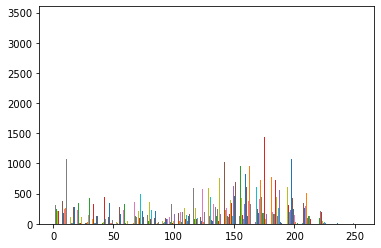

In [ ]:
# after rescale
im_resacal = read_dcm_image(data_info_df.loc[10,:])
plt.hist(im_resacal, bins=20)

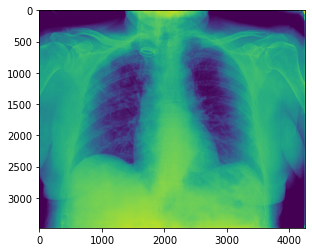

In [ ]:
#show the images after rescale
plt.imshow(im_resacal)

### 3.3 Rescale All the Image and Save Them to PNG Format

In [ ]:
image_id = []
image_path = []
image_class = []

save_dir = './train/'

os.makedirs(save_dir, exist_ok=True)

for i in range(len(data_info_df)):
    # set keep_ratio=True to have original aspect ratio
    item = data_info_df.loc[i,:]
    save_path = os.path.join(save_dir, item['image_id']+'.png')
    rescale_im = read_dcm_image(item)
    image_id.append(item['image_id'])
    image_class.append(item['class_name'])
    image_path.append(save_path)
    im = Image.fromarray(rescale_im)
    im.save(save_path)

In [ ]:
# Create a data frame containing the information of the images

rescaled_image_info = pd.DataFrame({'image_id':image_id,'image_path': image_path, 'image_class':image_class})
rescaled_image_info.head()
rescaled_image_info.to_csv('./rescaled_image_info.csv',index=False)

In [ ]:
rescaled_image_info.shape

## 4 Get the Rescaled Image Data

### 4.1 Read the CSV File From to Get the Rescaled Image Path and the Image Class

In [4]:
img_info_df_path = '/content/drive/MyDrive/DeepLearningModel/SIIM-FISABIO-RSNA_COVID-19_Detection/data/rescaled_image_info.csv'
subpath = '/content/drive/MyDrive/DeepLearningModel/SIIM-FISABIO-RSNA_COVID-19_Detection/data/train'
img_info = pd.read_csv(img_info_df_path)
img_info['image_path'] = img_info['image_path'].str.replace('./train', subpath)
img_info.head()

,image_id,image_path,image_class
0,000a312787f2_image,/content/drive/MyDrive/DeepLearningModel/SIIM-...,Typical Appearance
1,000c3a3f293f_image,/content/drive/MyDrive/DeepLearningModel/SIIM-...,Negative for Pneumonia
2,0012ff7358bc_image,/content/drive/MyDrive/DeepLearningModel/SIIM-...,Typical Appearance
3,001398f4ff4f_image,/content/drive/MyDrive/DeepLearningModel/SIIM-...,Atypical Appearance
4,001bd15d1891_image,/content/drive/MyDrive/DeepLearningModel/SIIM-...,Typical Appearance


### 4.2 Split the DataFrame to Train and Test Set

In [5]:
train, test = train_test_split(img_info, test_size=0.2, random_state=42, shuffle=True)
train = train.reset_index()
test = test.reset_index()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

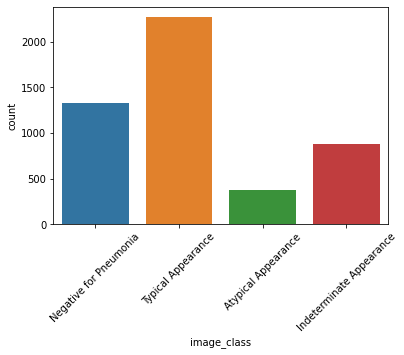

In [6]:
sns.countplot(train.image_class)
plt.xticks(rotation=45)

In [7]:
train.shape

(4843, 4)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

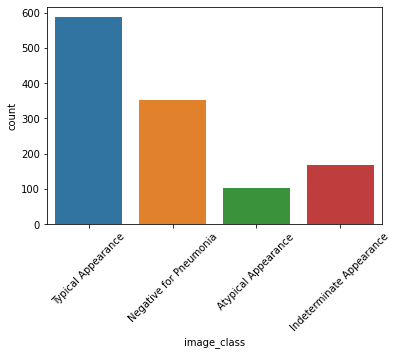

In [8]:
sns.countplot(test.image_class)
plt.xticks(rotation=45)

In [9]:
test.shape

(1211, 4)

## 5 Vgg16 Model 

* Can not apply pre-train model in this case because the image set are all 2 dimension

### 5.1 Create the Image Data Generator for Training and Test Set

* Apply image augmentation to train set. Note: ImageDataGenerator will NOT add new images to your data set in a sense that it will not make your epochs bigger. Instead, in each epoch it will provide slightly altered images (depending on your configuration). It will always generate new images, no matter how many epochs you have. So in each epoch model will train on different images, but not too different. This should prevent overfitting and in some way simulates online learning.

In [ ]:
batch_size = 64

# rescale each pixel into range [0,1]
train_datagen = ImageDataGenerator(rescale=1.0/255.0, 
                             rotation_range = 15,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip = True
                             )
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_set = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='image_path',
    y_col='image_class',
    shuffle=True,
    target_size=(224,224),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    #subset='training',
    seed=42)

validation_set = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='image_path',
    y_col='image_class', 
    shuffle=True,
    target_size=(224,224),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    #subset='validation',
    seed=42)

Found 4843 validated image filenames belonging to 4 classes.
Found 1211 validated image filenames belonging to 4 classes.


In [ ]:
train_set[0][0].shape

(64, 224, 224, 1)

* Batch size is 64 for training set, each image with size 224\*224\*1

### 5.2 Build the Vgg16 Model 

In [62]:
input_shape = (224,224,1)
vgg16 =VGG16(include_top=False,
             input_shape = input_shape,
             pooling = 'avg', # can be 'avg' or 'max'
             weights=None  # set weight to None beaause I am not using the pretrain model
             ) 
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [63]:
# Adding some layers to the end of the Vgg16 model

model = Sequential([
    vgg16,
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.40),
    #Dense(512, activation='relu'),
    #BatchNormalization(),
    #Dropout(0.35),
    #Dense(256, activation='relu'),
    #BatchNormalization(),
    #Dropout(0.40),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.35),
    #Dense(128, activation='relu'),
    #BatchNormalization(),
    #Dropout(0.35),
    Flatten(),
    Dense(4,activation='softmax')
    ])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14713536  
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)              

### 5.3 Train the Vgg16 Model

In [64]:
f1Score = tfa.metrics.F1Score(num_classes=4, threshold=0.5, average='micro')

model.compile(
    optimizer = optimizers.Adam(learning_rate=0.00001), 
    loss = 'categorical_crossentropy',               
    metrics=['accuracy'])#,f1Score])

In [72]:
callback = EarlyStopping(
        monitor='val_loss', min_delta=0, patience=0, verbose=0,
        mode='auto', baseline=None, restore_best_weights=False)

history = model.fit(train_set, 
                    validation_data = validation_set, 
                    steps_per_epoch=train_set.n//train_set.batch_size,
                    validation_steps=validation_set.n//validation_set.batch_size,
                    epochs = 100,
                    #callbacks=[callback]
                             )

Epoch 1/100
75/75 [==============================] - 237s 3s/step - loss: 1.0248 - accuracy: 0.6100 - val_loss: 1.0362 - val_accuracy: 0.6128
Epoch 2/100
75/75 [==============================] - 231s 3s/step - loss: 1.0162 - accuracy: 0.6135 - val_loss: 1.0642 - val_accuracy: 0.5998
Epoch 3/100
75/75 [==============================] - 232s 3s/step - loss: 1.0257 - accuracy: 0.6054 - val_loss: 1.0003 - val_accuracy: 0.6319
Epoch 4/100
75/75 [==============================] - 232s 3s/step - loss: 1.0143 - accuracy: 0.6139 - val_loss: 1.0399 - val_accuracy: 0.6267
Epoch 5/100
75/75 [==============================] - 231s 3s/step - loss: 1.0167 - accuracy: 0.6091 - val_loss: 0.9935 - val_accuracy: 0.6354
Epoch 6/100
75/75 [==============================] - 231s 3s/step - loss: 1.0090 - accuracy: 0.6135 - val_loss: 1.0644 - val_accuracy: 0.6059
Epoch 7/100
75/75 [==============================] - 231s 3s/step - loss: 1.0072 - accuracy: 0.6091 - val_loss: 1.4749 - val_accuracy: 0.5043
Epoch 

### 5.4 Plot the Training Result of Vgg16 Model

In [75]:
out_put_df = pd.DataFrame({'Training Loss':history.history['loss'], 
                        'Validation Loss':history.history['val_loss'],
                        'Training Accuracy': history.history['accuracy'],
                        'Validation Accuracy':history.history['val_accuracy']})
out_put = out_put.append(out_put_df, ignore_index=True)
out_put.shape

(150, 4)

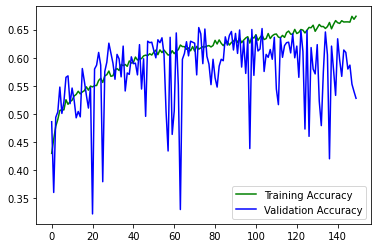

In [76]:
plt.plot(out_put['Training Accuracy'], color='green', label = 'Training Accuracy')
plt.plot(out_put['Validation Accuracy'], color='blue', label = 'Validation Accuracy')
plt.legend()

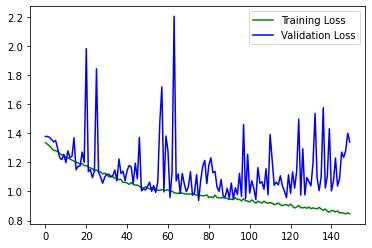

In [77]:
plt.plot(out_put['Training Loss'], color='green', label = 'Training Loss')
plt.plot(out_put['Validation Loss'], color='blue', label = 'Validation Loss')
plt.legend()

* The validation loss and accuracy are very unstable.

* At about Epoch=90, the trend of the validtion accuracy is about to go down. 

* At about Epoch=90, the trend of the validtion loss is about to go up. 

* The model at about Epoch=90 started overfitting

### 5.5 Save the Model

In [78]:
model_path='/content/drive/MyDrive/DeepLearningModel/SIIM-FISABIO-RSNA_COVID-19_Detection/Model/'
model.save(model_path+'Vgg16_224_64_1e-5.h5', save_format='h5')

### 5.6 Load Model

In [79]:
# load model
export_path = os.path.join(os.getcwd(), 'Vgg16_224_64_1e-5.h5')
dependencies = {
    'F1Score': f1Score
}
Model=models.load_model(export_path,custom_objects=dependencies)
Model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14713536  
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)              

## 6 Resnet50 Model

In [10]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint

### 6.1 Image Data Generation for Resnet50 

In [31]:
batch_size = 64

# rescale each pixel into range [0,1]
train_datagen = ImageDataGenerator(
                             rescale=1./255,
                             rotation_range = 15,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             #zoom_range=[0.5,1.0],
                             #brightness_range=[0.5,1.0],
                             horizontal_flip = True
                             )
test_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='image_path',
    y_col='image_class',
    shuffle=True,
    target_size=(224,224),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training',
    seed=1)

validation_set = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='image_path',
    y_col='image_class', 
    shuffle=True,
    target_size=(224,224),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    #subset='validation',
    seed=1)

Found 4843 validated image filenames belonging to 4 classes.
Found 1211 validated image filenames belonging to 4 classes.


In [12]:
train_set[0][0][0].shape

(224, 224, 1)

### 6.2 Create the Resnet50 Model

In [32]:
resnet50 = ResNet50(include_top=False, 
                    weights=None,
                    input_shape=(224,224,1))
#resnet50.summary()

# Adding some layers to the end of the resnet50 model

model = Sequential([
    resnet50,
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.20),
    #Dense(512, activation='relu'),
    #BatchNormalization(),
    #Dropout(0.35),
    #Dense(256, activation='relu'),
    #BatchNormalization(),
    #Dropout(0.35),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.20),
    #Dense(128, activation='relu'),
    #BatchNormalization(),
    #Dropout(0.35),
    Flatten(),
    Dense(4,activation='softmax')
    ])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23581440  
_________________________________________________________________
dense_9 (Dense)              (None, 7, 7, 512)         1049088   
_________________________________________________________________
batch_normalization_6 (Batch (None, 7, 7, 512)         2048      
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 7, 512)         0         
_________________________________________________________________
dense_10 (Dense)             (None, 7, 7, 256)         131328    
_________________________________________________________________
batch_normalization_7 (Batch (None, 7, 7, 256)         1024      
_________________________________________________________________
dropout_7 (Dropout)          (None, 7, 7, 256)        

### 6.3 Train the Resnt50 Model

In [33]:
f1Score = tfa.metrics.F1Score(num_classes=4, threshold=0.5, average='micro')

model.compile(
    optimizer = optimizers.Adam(learning_rate=0.00005), 
    loss = 'categorical_crossentropy',               
    metrics=['accuracy'])#,f1Score])

In [34]:
checkpoint_filepath = '/content/drive/MyDrive/DeepLearningModel/SIIM-FISABIO-RSNA_COVID-19_Detection/Model/'
callback = ModelCheckpoint(filepath=checkpoint_filepath,
                           save_weights_only=True,
                           monitor='val_accuracy',
                           mode='max',
                           save_best_only=True)

history = model.fit(train_set, 
                    validation_data = validation_set, 
                    steps_per_epoch=math.ceil(train_set.n//train_set.batch_size),
                    validation_steps=validation_set.n//validation_set.batch_size,
                    epochs = 50,
                    callbacks=[callback])

Epoch 1/50
75/75 [==============================] - 239s 3s/step - loss: 1.7678 - accuracy: 0.3624 - val_loss: 1.3616 - val_accuracy: 0.4878
Epoch 2/50
75/75 [==============================] - 229s 3s/step - loss: 1.6669 - accuracy: 0.3815 - val_loss: 1.3307 - val_accuracy: 0.4852
Epoch 3/50
75/75 [==============================] - 228s 3s/step - loss: 1.6037 - accuracy: 0.3921 - val_loss: 1.4691 - val_accuracy: 0.4826
Epoch 4/50
75/75 [==============================] - 227s 3s/step - loss: 1.5737 - accuracy: 0.3955 - val_loss: 1.4840 - val_accuracy: 0.4826
Epoch 5/50
75/75 [==============================] - 226s 3s/step - loss: 1.5515 - accuracy: 0.4177 - val_loss: 1.6092 - val_accuracy: 0.4792
Epoch 6/50
75/75 [==============================] - 226s 3s/step - loss: 1.5122 - accuracy: 0.4105 - val_loss: 1.4957 - val_accuracy: 0.4783
Epoch 7/50
75/75 [==============================] - 226s 3s/step - loss: 1.4600 - accuracy: 0.4229 - val_loss: 1.3393 - val_accuracy: 0.4757
Epoch 8/50
75

### 6.4 Plot the Training Result of Resnet50 Model

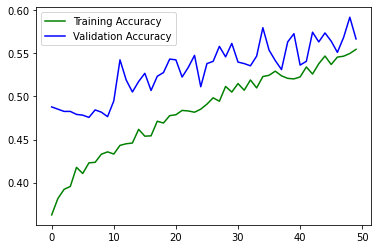

In [35]:
plt.plot(history.history['accuracy'], color='green', label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], color='blue', label = 'Validation Accuracy')
plt.legend()

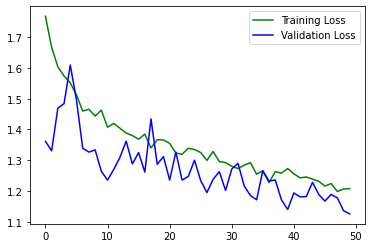

In [36]:
plt.plot(history.history['loss'], color='green', label = 'Training Loss')
plt.plot(history.history['val_loss'], color='blue', label = 'Validation Loss')
plt.legend()

* According to the plot above, the training and validation loss have train to going down.
* The results are more stable than the results of non-pre-trained vgg16 model. We can train more epoches on it. 

### 6.5 Save the Model

In [37]:
model_path='/content/drive/MyDrive/DeepLearningModel/SIIM-FISABIO-RSNA_COVID-19_Detection/Model/'
model.save(model_path+'resnet50_224_5e-5(b64).h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


### 6.6 Load Model

In [25]:
# load model
savedModel=models.load_model(model_path+'resnet50_224_1e-5(b64).h5')
savedModel.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23581440  
_________________________________________________________________
dense_6 (Dense)              (None, 7, 7, 512)         1049088   
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 512)         2048      
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 512)         0         
_________________________________________________________________
dense_7 (Dense)              (None, 7, 7, 256)         131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 7, 256)         1024      
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 256)        

## 7 Pre-trained Vgg16 Model

### 7.1 Image Data Generation for Resnet50 

In [101]:
BATCH_SIZE = 32

dataflow_kwargs = dict(
                       target_size=(224, 224),
                       batch_size=BATCH_SIZE,
                       interpolation="lanczos"
                      )


valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   validation_split=0.9999)

valid_generator = valid_datagen.flow_from_dataframe(dataframe=test,
                                                    x_col='image_path',
                                                    y_col='image_class',
                                                    subset="validation",
                                                    shuffle=True,
                                                    seed=42,
                                                    **dataflow_kwargs)

train_datagen = ImageDataGenerator(rotation_range=40,
                                   horizontal_flip=True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(dataframe=train,
                                                    x_col='image_path',
                                                    y_col='image_class',
                                                    subset="training",
                                                    shuffle=True,
                                                    seed=42,
                                                    **dataflow_kwargs)

print('classes :', train_generator.class_indices)

Found 1210 validated image filenames belonging to 4 classes.
Found 4843 validated image filenames belonging to 4 classes.
classes : {'Atypical Appearance': 0, 'Indeterminate Appearance': 1, 'Negative for Pneumonia': 2, 'Typical Appearance': 3}


### 7.2 Create the Vgg16 Model and Load the Weights


In [102]:
base_model = VGG16(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet")


for layer in base_model.layers:
    layer.trainable=False

In [103]:
#Adding layers to the end of the vgg16 moedl
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

### 7.3 Train the Model

In [108]:
filepath = model_path+'best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)

callback_list = [earlystopping, checkpoint]

In [ ]:
OPT = Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[AUC(name = 'auc'), 'accuracy'],
              optimizer=OPT)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model_history=model.fit(train_generator,
                        validation_data=valid_generator,
                        epochs = 50,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/50
152/152 [==============================] - 773s 5s/step - loss: 1.3667 - auc: 0.7366 - accuracy: 0.4947 - val_loss: 1.5833 - val_auc: 0.7438 - val_accuracy: 0.5314

Epoch 00001: val_auc improved from -inf to 0.74384, saving model to /content/drive/MyDrive/DeepLearningModel/SIIM-FISABIO-RSNA_COVID-19_Detection/Model/best_weights.hdf5
Epoch 2/50
152/152 [==============================] - 773s 5s/step - loss: 1.2076 - auc: 0.7664 - accuracy: 0.5389 - val_loss: 1.2168 - val_auc: 0.7553 - val_accuracy: 0.5413

Epoch 00002: val_auc improved from 0.74384 to 0.75530, saving model to /content/drive/MyDrive/DeepLearningModel/SIIM-FISABIO-RSNA_COVID-19_Detection/Model/best_weights.hdf5
Epoch 3/50
152/152 [==============================] - 770s 5s/step - loss: 1.1479 - auc: 0.7749 - accuracy: 0.5447 - val_loss: 1.0844 - val_auc: 0.8114 - val_accuracy: 0.6099

Epoch 00003: val_auc improved from 0.75530 to 0.81136, saving model to /content/drive/MyDrive/DeepLearningModel/SIIM-FISABIO-RSNA

### 7.4 Plot the Training Result of the Pre-trained Vgg16 Model

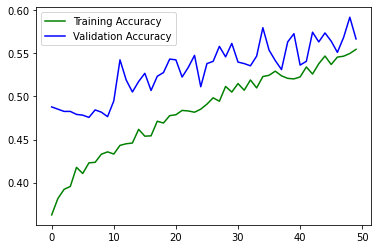

In [ ]:
plt.plot(model_history['accuracy'], color='green', label = 'Training Accuracy')
plt.plot(model_history['val_accuracy'], color='blue', label = 'Validation Accuracy')
plt.legend()

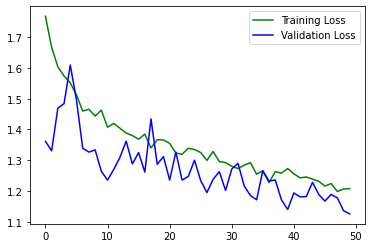

In [ ]:
plt.plot(model_history['loss'], color='green', label = 'Training Loss')
plt.plot(model_history['val_loss'], color='blue', label = 'Validation Loss')
plt.legend()

* Pre-trained Vgg16 Model produce the best outcome so far. It got a val_auc=0.8287 and val_accuracy=0.6190, but still need further training.